# Importing and preprocessing.

In [1]:
import cooler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary Data Visualisation.


In [83]:
c = cooler.Cooler("/gss/home/a.kuznetsov/data_new/8B_2000_down.cool")
nonbal = c.matrix(balance=False)[:, :]
bal = c.matrix(balance=True)[:, :]

In [3]:
bal.shape

(17174, 17174)

Text(0.5, 1.0, 'Balanced heatmap Fragment')

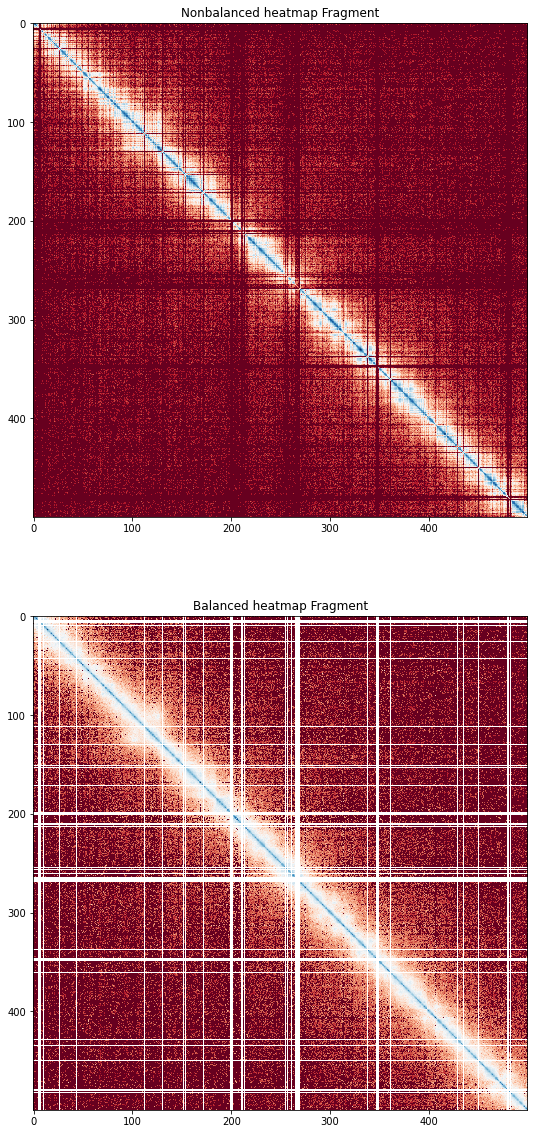

In [5]:
fig, axs = plt.subplots(2, figsize = (10, 20))
axs[0].imshow(np.log(nonbal[1000:1500, 1000:1500] + 1), cmap='RdBu', interpolation='none')
axs[0].set_title('Nonbalanced heatmap Fragment')
axs[1].imshow(np.log(bal[1000:1500, 1000:1500] + 10**(-4)), cmap='RdBu', interpolation='none')
axs[1].set_title('Balanced heatmap Fragment')

Text(0.5, 1.0, 'Balanced heatmap Fragment')

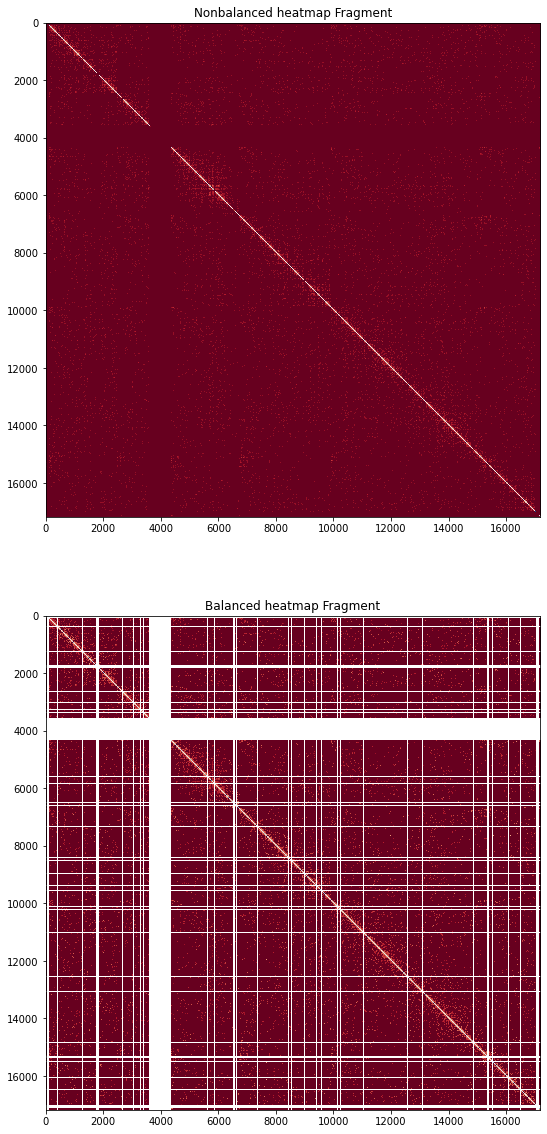

In [164]:
fig, axs = plt.subplots(2, figsize = (10, 20))
axs[0].imshow(np.log(nonbal + 1), cmap='RdBu', interpolation='none')
axs[0].set_title('Nonbalanced heatmap Fragment')
axs[1].imshow(np.log(bal + 10**(-4)), cmap='RdBu', interpolation='none')
axs[1].set_title('Balanced heatmap Fragment')

We see a lot of rows, that became NaNs, probably due to the part of cooler normalization procedure - blacklisting: --min-nnz (Ignore bins from the contact matrix whose marginal number of nonzeros is less than this number. [default: 10])
So we have to take it into account later.

# Contact Map to Distance Transition. (prev. iteration)

In [6]:
#A function for contact map - distance transition:
def mydist_balanced(B):
    B1 = np.nan_to_num(B) #Replace all NaNs with zeros;
    B1 = np.where(B1==0.0, np.unique(B1)[1]/2, B1) #Replace all zeros with the minimal nonzero value / 2;
    B1 = B1 / B1.max() if B1.max() > 1. else B1 #Now all the elements are <= 1;
    B1 = np.log10(B1) #Log-transformation: all values are <= 0;
    B1 = B1 * (-1) #Now all values are >= 0;
    B1 = B1 / B1.max() #Now all values are in the [0; 1] interval; 
    np.fill_diagonal(B1, 0.) #Zero main diagonal for subsequent topological analysis.
    return B1

In [44]:
bal.shape

(17174, 17174)

We have to remember, that our function does not output Euclidian distances per se, because the obtained distances won't obey triangle inequality (|a| + |b| ≥ |a + b|). But our output is useful for subsequent Topological Data Analysis and could be seen as some kind of similarity function, therefore in the following sections we will still use the term "Distance" for the description of that output.

# Contact Map to Distance Transition (current iteration)

In [45]:
def observe_expect(M):
    M1 = np.nan_to_num(M) #Replace all NaNs with zeros;
    X = np.zeros(shape=M1.shape)
    X += np.diagflat(np.ones(shape=M1.diagonal(0).shape)*nonbal.diagonal(0).mean(),)
    for i in range(1, X.shape[0]):
        X += np.diagflat(np.ones(shape=M1.diagonal(i).shape)*nonbal.diagonal(i).mean(), k=i) + np.diagflat(np.ones(shape=M1.diagonal(i).shape)*nonbal.diagonal(i).mean(), k=-i)
        if i % 1 == 0:
            print(f'Done for {i}')
    M1 = np.divide(M1, X)
    return M1

In [52]:
def make_expected_vals(cooler, Ndiags):
    vals = {}
    mat = cooler.matrix(balance=True, sparse=True)
    diags = scipy.sparse.triu(scipy.sparse.tril(mat, Ndiags), 0, 'dia')
    for i in range(Ndiags):
        if i not in vals:
            vals[i] = []
        arr = diags.data[i][diags.data[i]==diags.data[i]]
        vals[i].append([np.mean(arr), np.std(arr), arr.shape[0]])#Std in case we want to do z-score
    avals = []
    for d in vals:
        l = np.sum([i[2] for i in vals[d]])
        m = np.array([i[0]*i[2] for i in vals[d]]).sum()/l
        s = np.array([i[1]*i[2] for i in vals[d]]).sum()/l
        avals.append((m ,s))
    return np.array(avals)

In [3]:
import scipy
make_expected_vals(c, 200)

NameError: name 'make_expected_vals' is not defined

In [4]:
from scipy.sparse import csr_matrix

In [52]:
def p_dist(M):
    ind = np.isnan(M).all(axis=1)
    M1 = M[~ind][:, ~ind]
    M1_cor = np.corrcoef(M1)
    M1_cor = np.nan_to_num(M1_cor)
    M1_e = np.sqrt(1 - M1_cor)
    M1_e = (M1_e + M1_e.transpose())/2
    return M1_e

In [84]:
ind = np.isnan(bal).all(axis=1)
z = bal[~ind][:, ~ind]
z.shape

(15287, 15287)

In [6]:
csr_m = csr_matrix(nonbal)

In [51]:
Z

array([[0.00000000e+00, 3.71852179e-01, 5.33651515e-01, ...,
        9.95865860e-01, 9.96037500e-01, 9.94374568e-01],
       [3.71852179e-01, 0.00000000e+00, 3.73940420e-01, ...,
        9.95349401e-01, 9.57720180e-01, 9.72377645e-01],
       [5.33651515e-01, 3.73940420e-01, 1.05367121e-08, ...,
        9.96011830e-01, 9.97404848e-01, 9.92803947e-01],
       ...,
       [9.95865860e-01, 9.95349401e-01, 9.96011830e-01, ...,
        0.00000000e+00, 1.00000685e+00, 9.98670701e-01],
       [9.96037500e-01, 9.57720180e-01, 9.97404848e-01, ...,
        1.00000685e+00, 1.05367121e-08, 5.61892199e-01],
       [9.94374568e-01, 9.72377645e-01, 9.92803947e-01, ...,
        9.98670701e-01, 5.61892199e-01, 0.00000000e+00]])

In [8]:
X = np.zeros(z.shape[0])
for i in range(z.shape[0]):
    X[i] = np.mean(z.diagonal(i))

In [9]:
print(X[:20])

[0.22165709 0.08376353 0.03608302 0.02512882 0.01981968 0.01697823
 0.01500454 0.01359362 0.01239979 0.01125704 0.010224   0.00917825
 0.0083305  0.00747397 0.00677815 0.00611401 0.00550958 0.00498866
 0.00453598 0.00410984]


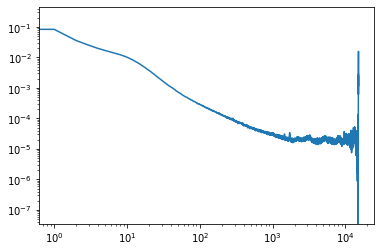

In [10]:
plt.loglog(X)

In [11]:
from scipy.linalg import toeplitz
expected = toeplitz(X)
expected

array([[0.22165709, 0.08376353, 0.03608302, ..., 0.00650139, 0.00365093,
        0.00278655],
       [0.08376353, 0.22165709, 0.08376353, ..., 0.01588152, 0.00650139,
        0.00365093],
       [0.03608302, 0.08376353, 0.22165709, ..., 0.00869193, 0.01588152,
        0.00650139],
       ...,
       [0.00650139, 0.01588152, 0.00869193, ..., 0.22165709, 0.08376353,
        0.03608302],
       [0.00365093, 0.00650139, 0.01588152, ..., 0.08376353, 0.22165709,
        0.08376353],
       [0.00278655, 0.00365093, 0.00650139, ..., 0.03608302, 0.08376353,
        0.22165709]])

In [19]:
res = np.nan_to_num(z)

In [20]:
res

array([[9.88986558e-02, 3.69205325e-01, 9.89827464e-02, ...,
        2.53822845e-03, 0.00000000e+00, 2.78655078e-03],
       [3.69205325e-01, 3.20937748e-01, 3.45832119e-01, ...,
        4.65581630e-02, 0.00000000e+00, 7.30186923e-03],
       [9.89827464e-02, 3.45832119e-01, 5.66386002e-01, ...,
        1.54540187e-02, 0.00000000e+00, 1.69659306e-02],
       ...,
       [2.53822845e-03, 4.65581630e-02, 1.54540187e-02, ...,
        1.29348915e+00, 3.21664320e-02, 5.22071687e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.21664320e-02, 1.13139756e+01, 1.16534116e+00],
       [2.78655078e-03, 7.30186923e-03, 1.69659306e-02, ...,
        5.22071687e-03, 1.16534116e+00, 8.42526812e-01]])

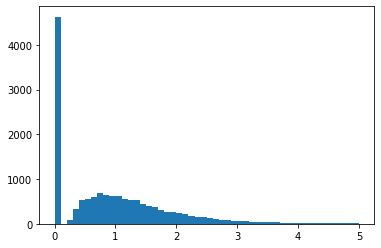

In [113]:
plt.hist(z.diagonal(50)/X[50], bins=50, range=(0, 5))
plt.show()


(array([180220., 790029., 743834., 490759., 362966., 292779., 247352.,
        218033., 197915., 185460., 178032., 177625., 179928., 186662.,
        194080., 204829., 216563., 225415., 235441., 242139., 249943.,
        253022., 255753., 255485., 254521., 250406., 246426., 241680.,
        235715., 227231., 221478., 213228., 206938., 197677., 190412.,
        182463., 175760., 167568., 161262., 154692., 146634., 141928.,
        134308., 128784., 122346., 117948., 112224., 107580., 103058.,
         98574.,  94006.,  89108.,  85644.,  82244.,  78622.,  75666.,
         72178.,  68140.,  65952.,  63050.,  60768.,  58676.,  55558.,
         52616.,  51428.,  49296.,  47854.,  45218.,  43772.,  41996.,
         40200.,  39096.,  37150.,  35660.,  34434.,  33479.,  32098.,
         30934.,  29916.,  28868.,  27976.,  26546.,  25850.,  24836.,
         24434.,  23450.,  22548.,  21966.,  21162.,  20360.,  19936.,
         19508.,  18334.,  17940.,  17484.,  16890.,  16104.,  15686.,
      

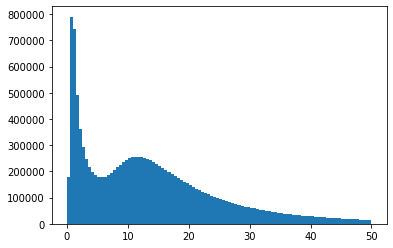

In [114]:
plt.hist(res.flatten(), bins=100, range=(0.01, 50))


In [115]:
(res < 0.0001).sum()

214732876

In [116]:
(res >= 0.0001).sum()

13942008

In [59]:
sum(sum(~np.isnan(res)))

228674884

KeyboardInterrupt: 

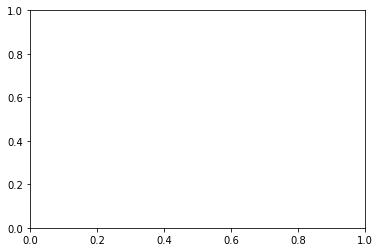

In [22]:
sns.kdeplot(res.flatten(), alpha=.5).set(title="The observed distribution of distances != 1", xlabel='Distance', ylabel='Frequency')

In [69]:
cor_m = np.corrcoef(res)

In [22]:
cor_m

array([[1.00000000e+00, 7.96274413e-01, 7.14589897e-01, ...,
        5.99212657e-02, 8.03260893e-04, 1.63124393e-02],
       [7.96274413e-01, 1.00000000e+00, 8.62851356e-01, ...,
        9.80561600e-02, 1.73148808e-03, 2.02357187e-02],
       [7.14589897e-01, 8.62851356e-01, 1.00000000e+00, ...,
        7.12172562e-02, 2.51627526e-03, 2.98180965e-02],
       ...,
       [5.99212657e-02, 9.80561600e-02, 7.12172562e-02, ...,
        1.00000000e+00, 2.35151578e-02, 2.42740398e-02],
       [8.03260893e-04, 1.73148808e-03, 2.51627526e-03, ...,
        2.35151578e-02, 1.00000000e+00, 8.59524370e-01],
       [1.63124393e-02, 2.02357187e-02, 2.98180965e-02, ...,
        2.42740398e-02, 8.59524370e-01, 1.00000000e+00]])

In [18]:
res.shape

array([[9.88986558e-02, 3.69205325e-01, 9.89827464e-02, ...,
        2.53822845e-03, 0.00000000e+00, 2.78655078e-03],
       [3.69205325e-01, 3.20937748e-01, 3.45832119e-01, ...,
        4.65581630e-02, 0.00000000e+00, 7.30186923e-03],
       [9.89827464e-02, 3.45832119e-01, 5.66386002e-01, ...,
        1.54540187e-02, 0.00000000e+00, 1.69659306e-02],
       ...,
       [2.53822845e-03, 4.65581630e-02, 1.54540187e-02, ...,
        1.29348915e+00, 3.21664320e-02, 5.22071687e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.21664320e-02, 1.13139756e+01, 1.16534116e+00],
       [2.78655078e-03, 7.30186923e-03, 1.69659306e-02, ...,
        5.22071687e-03, 1.16534116e+00, 8.42526812e-01]])

In [73]:
cor_m = np.nan_to_num(cor_m)

In [74]:
euc = np.sqrt(1 - cor_m)

## Testing.

In [83]:
test = mydist_balanced(bal)
print(test.min())
print(test.max())

0.0
1.0


In [95]:
plt.figure(figsize = (10, 10))
plt.imshow(test[1000:1500, 1000:1500], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

<>:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<ipython-input-95-d196e8e47231>:2: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  plt.imshow((z+1e-6)**-1[1000:1500, 1000:1500], cmap='RdBu', interpolation='none')


TypeError: 'int' object is not subscriptable

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Distance Map Fragment, cur. iteration')

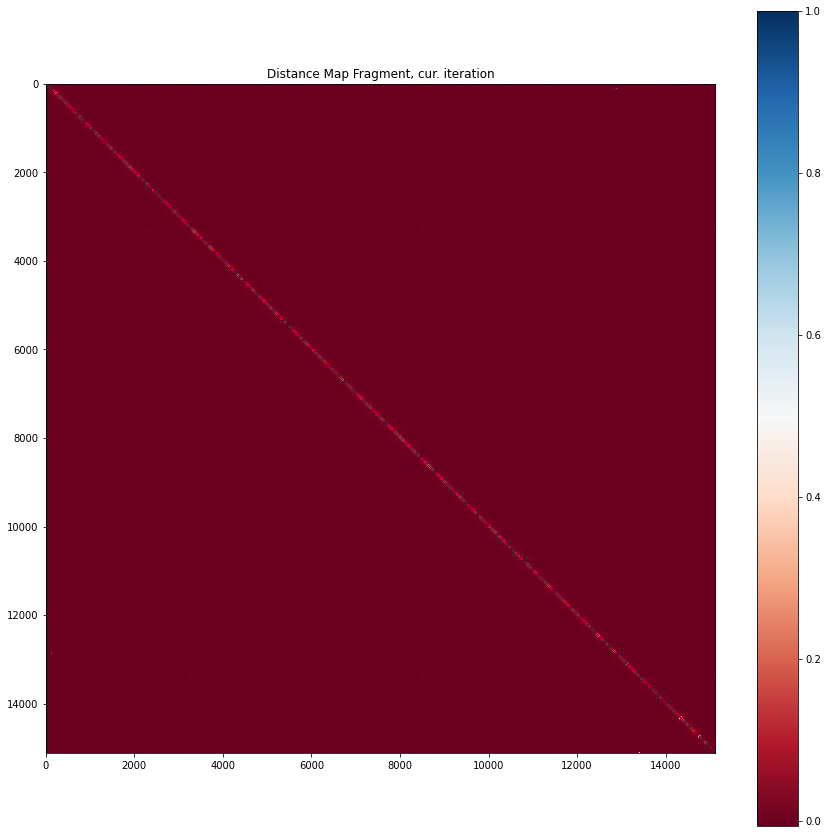

In [11]:
plt.figure(figsize = (15, 15))
plt.imshow(cor_m, cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, cur. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, cur. iteration')

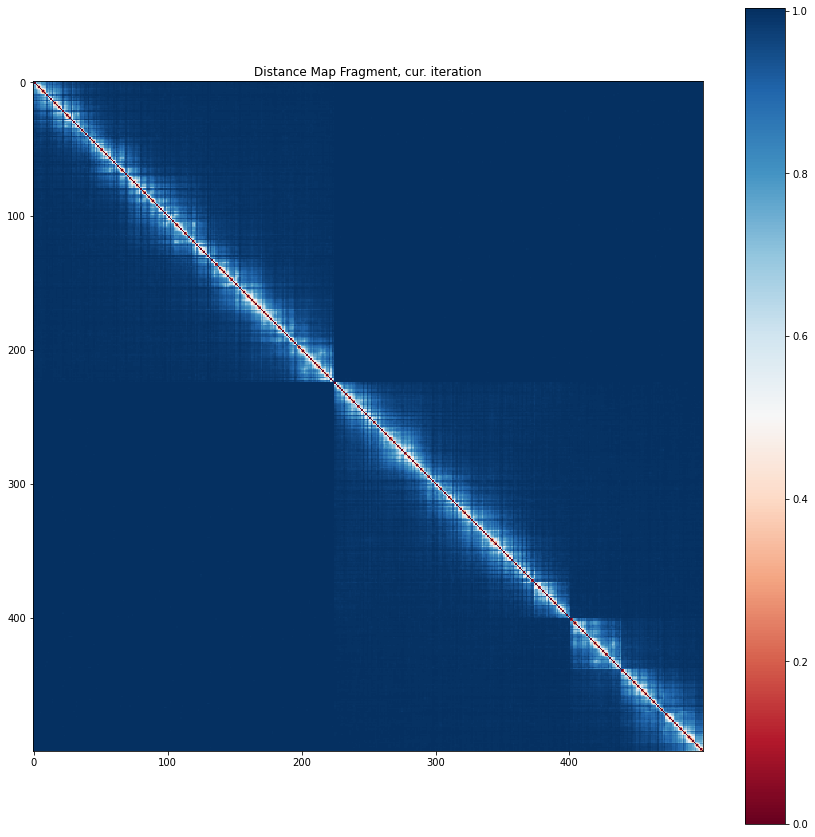

In [25]:
plt.figure(figsize = (15, 15))
plt.imshow(euc[2000:2500, 2000:2500], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, cur. iteration")

Text(0.5, 1.0, 'Distance Map Fragment')

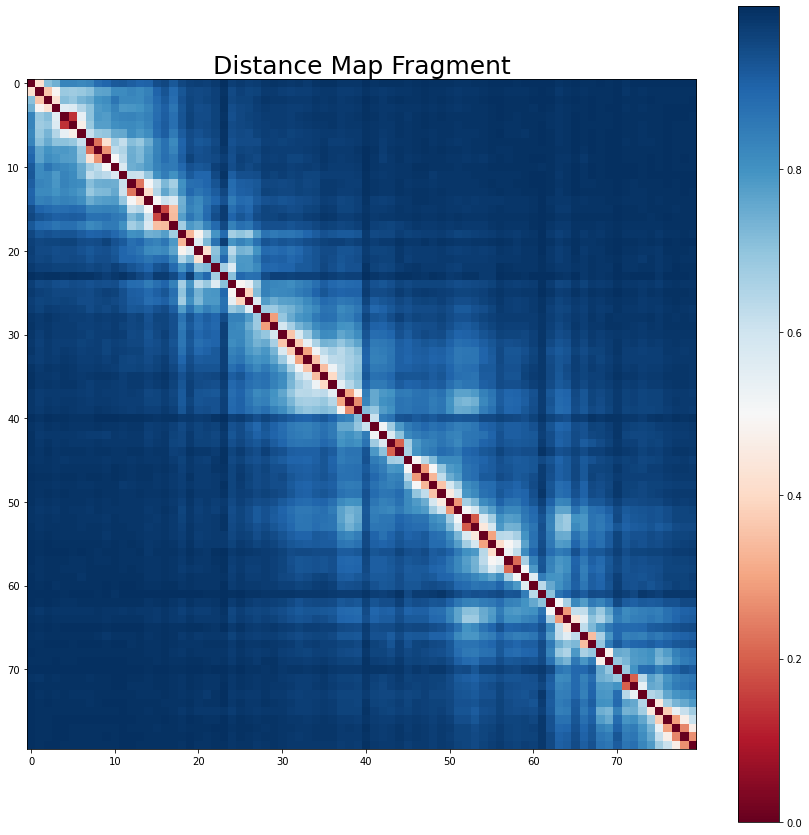

In [79]:
plt.figure(figsize = (15, 15))
plt.imshow(euc[1084:1164, 1084:1164], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment", fontsize=25)

Text(0.5, 1.0, 'Contact Map Fragment, log scale')

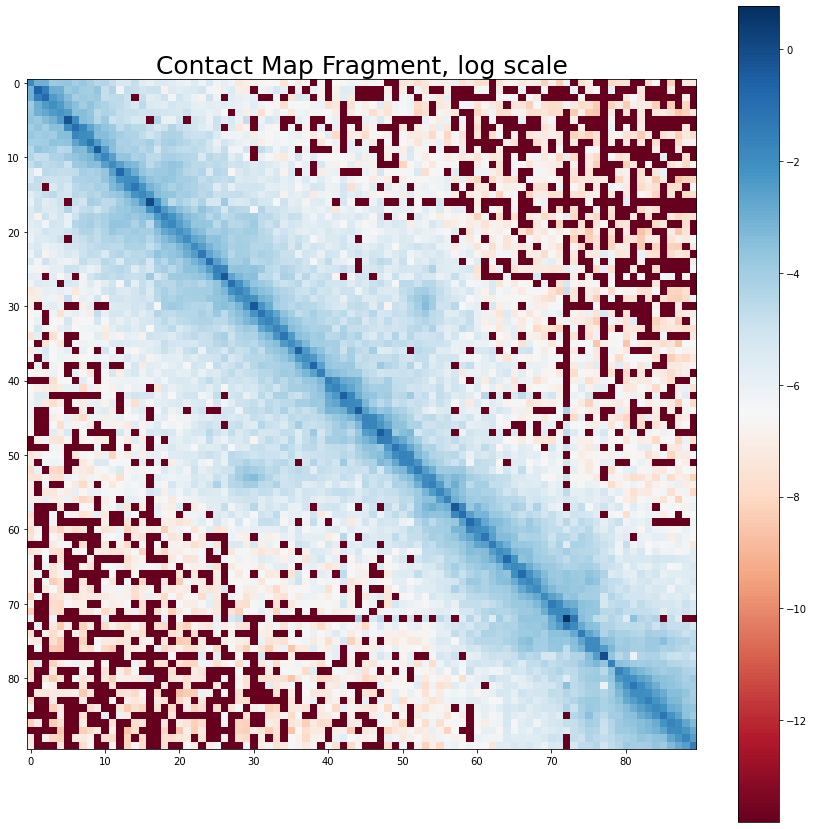

In [86]:
plt.figure(figsize = (15, 15))
plt.imshow(np.log(z+1e-6)[935:1025, 935:1025], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Contact Map Fragment, log scale", fontsize=25)

Text(0.5, 1.0, 'Distance Map Fragment, cur. iteration')

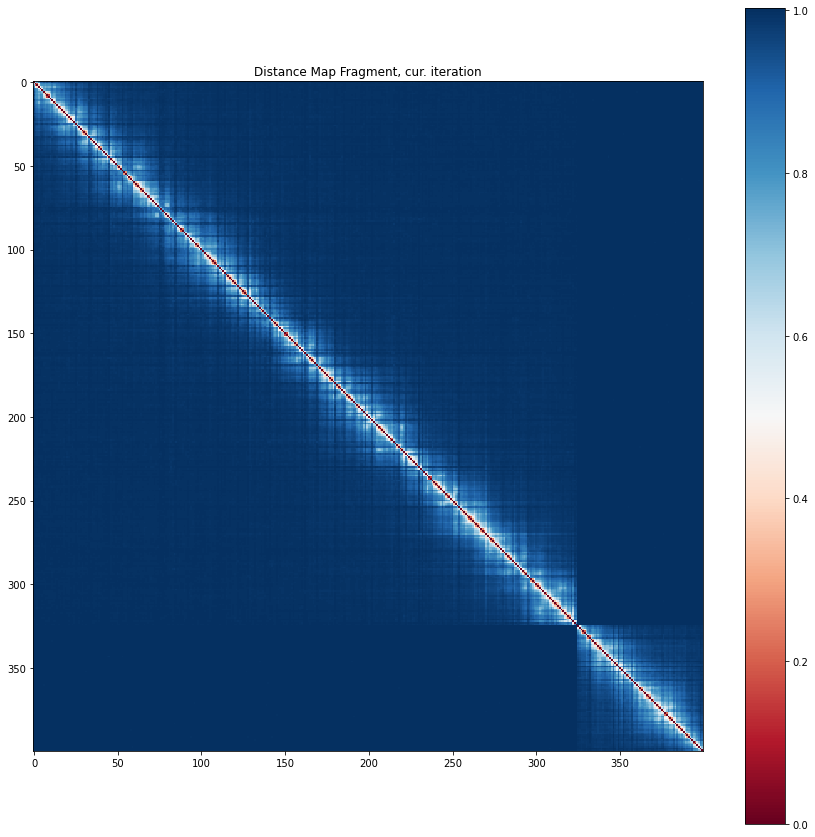

In [27]:
plt.figure(figsize = (15, 15))
plt.imshow(euc[1900:2300, 1900:2300], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, cur. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, cur. iteration')

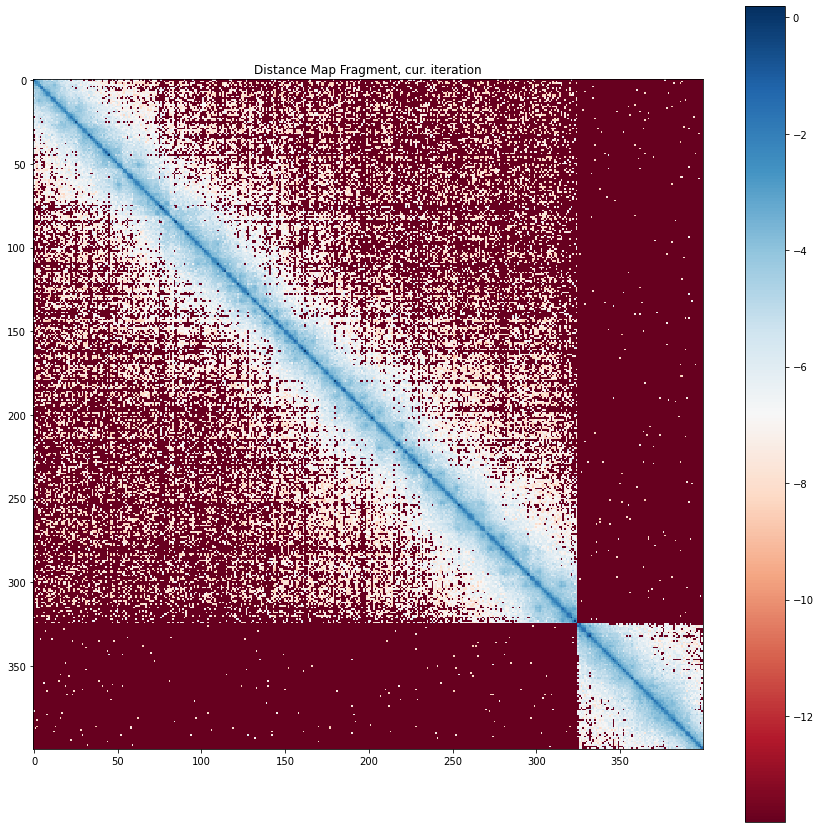

In [22]:
plt.figure(figsize = (15, 15))
plt.imshow(np.log(z+1e-6)[1900:2300, 1900:2300], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, cur. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, cur. iteration')

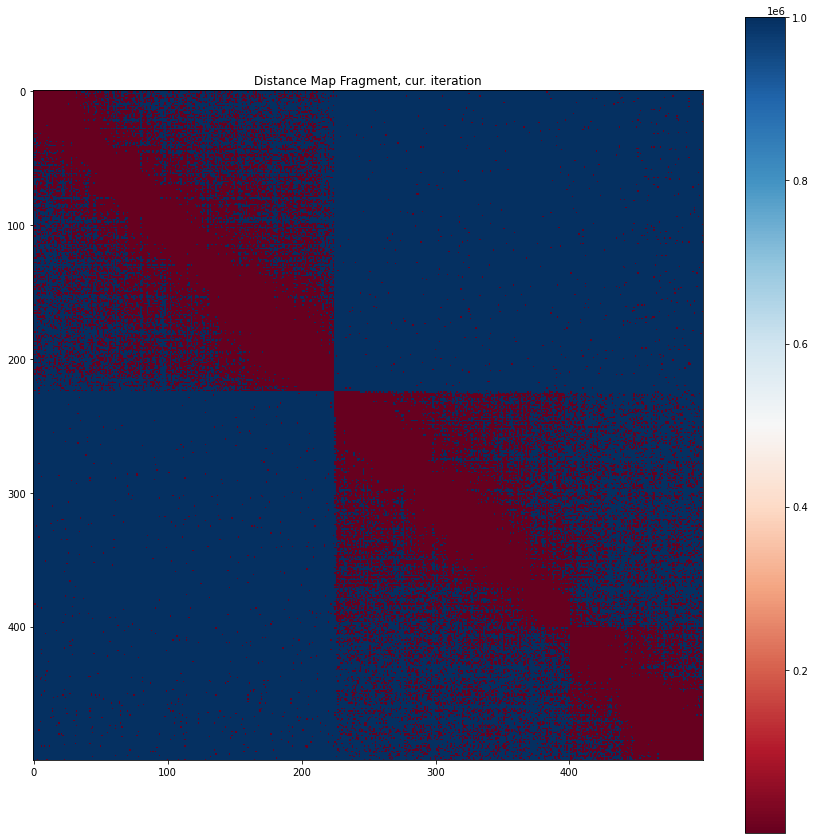

In [97]:
plt.figure(figsize = (15, 15))
plt.imshow(((z+1e-6)**-1)[2000:2500, 2000:2500], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, cur. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, prev. iteration')

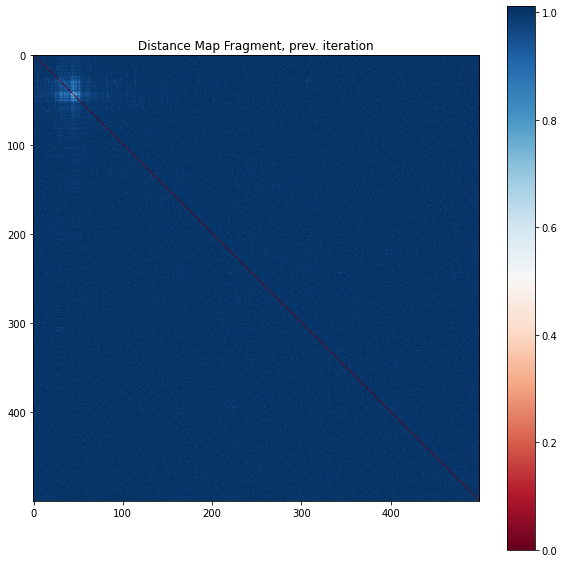

In [125]:
plt.figure(figsize = (10, 10))
plt.imshow(euc[1000:1500, 1000:1500], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, prev. iteration')

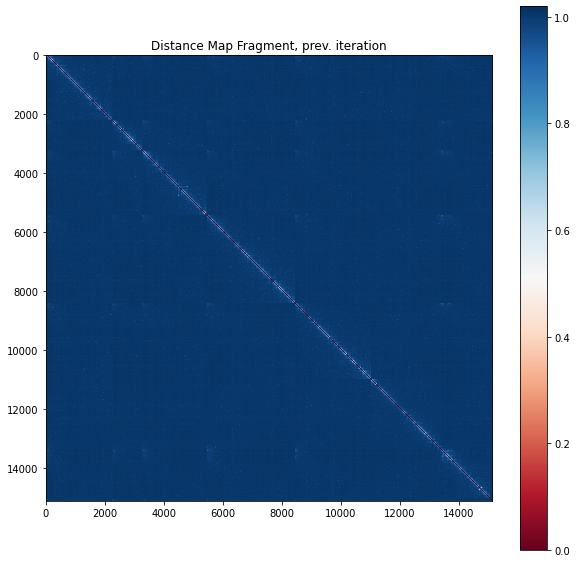

In [69]:
plt.figure(figsize = (10, 10))
plt.imshow((1 - cor_m)**3, cmap='RdBu', interpolation='none', )
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Distance'),
 Text(0.5, 1.0, 'The observed distribution of distances != 1')]

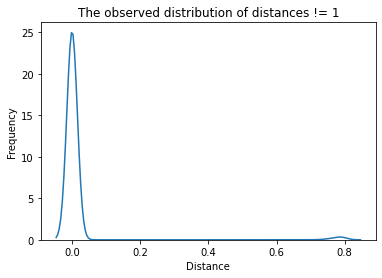

In [182]:
result = np.sqrt(1 - cor_m)
sns.kdeplot(result[result < 0.8].flatten(), alpha=.5).set(title="The observed distribution of distances != 1", xlabel='Distance', ylabel='Frequency')

In [189]:
np.sum(result<1)

166429090

In [190]:
np.sum(result<0.9)

135232

In [191]:
np.sum(result<0.8)

15420

In [192]:
np.sum(result<0.5)

15122

Text(0.5, 1.0, 'Distance Map Fragment, prev. iteration')

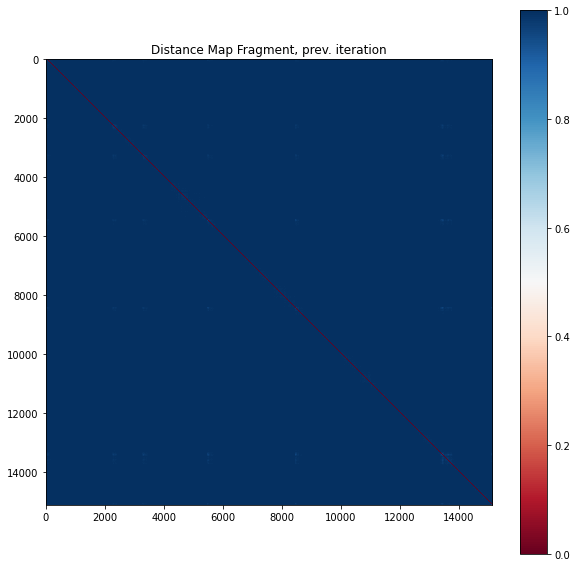

In [176]:
plt.figure(figsize = (10, 10))
plt.imshow(np.sqrt(1 - cor_m**2), cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, prev. iteration')

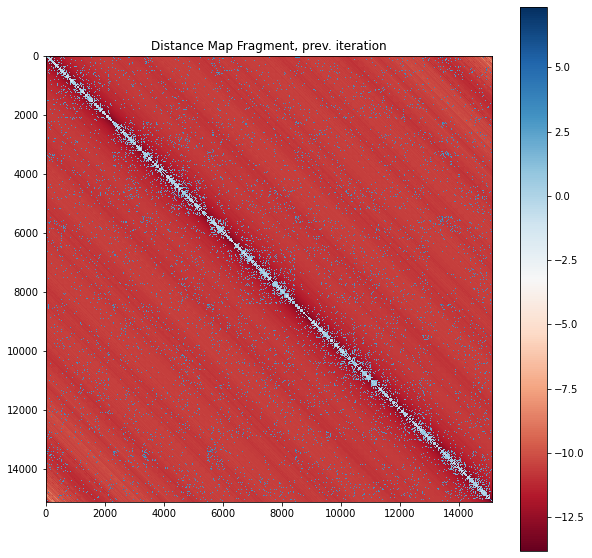

In [177]:
plt.figure(figsize = (10, 10))
plt.imshow(np.log(res+1e-6), cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

Text(0.5, 1.0, 'Distance Map Fragment, prev. iteration')

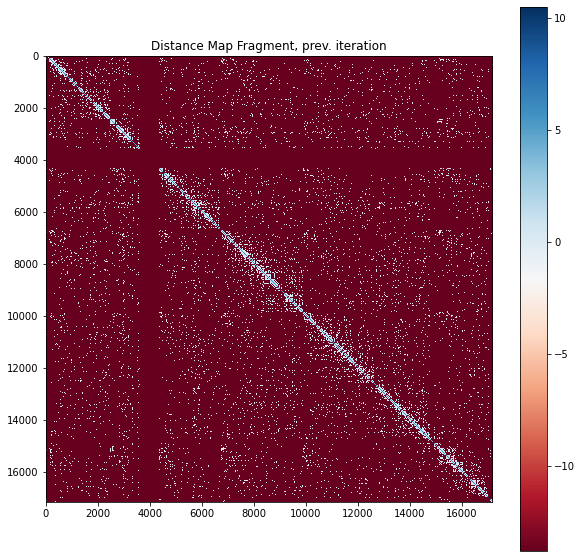

In [134]:
plt.figure(figsize = (10, 10))
plt.imshow(np.log(nonbal+1e-6), cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("Distance Map Fragment, prev. iteration")

Text(0.5, 1.0, 'Distance Histogram')

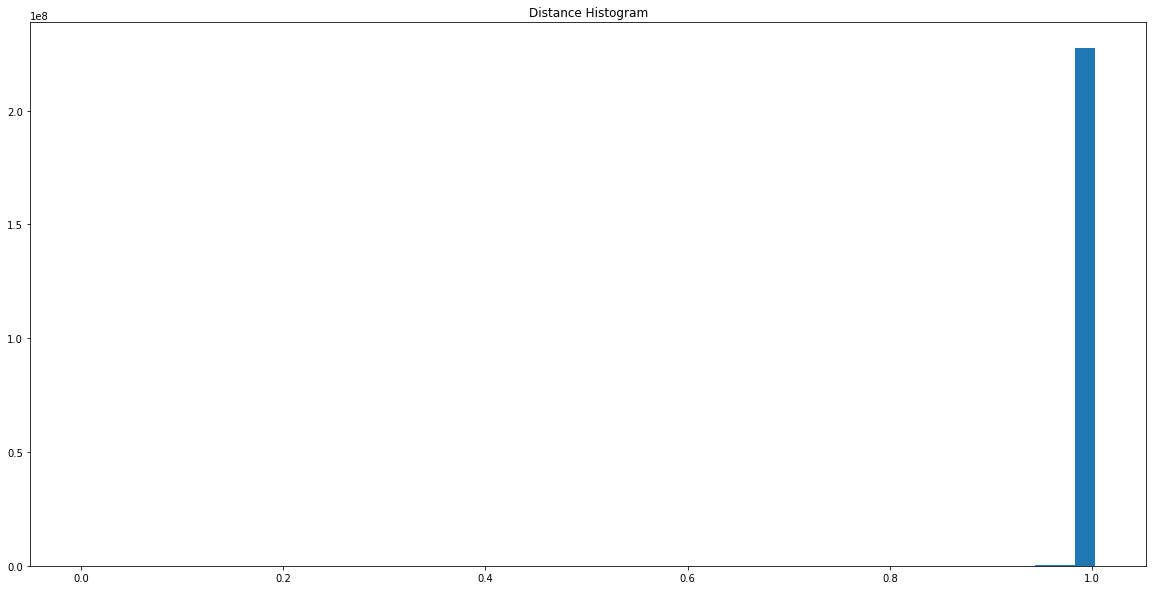

In [24]:
plt.figure(figsize = (20, 10))
plt.hist(euc.flatten(), bins = 50)
plt.title("Distance Histogram")

Most of the values in the distance matrix = 1, because all of them come from the cells = 0 or NaN from contact map. Let's see the distribution of all the values != 0:

In [25]:
X = euc.flatten()

In [26]:
y = X[X < 1.0]

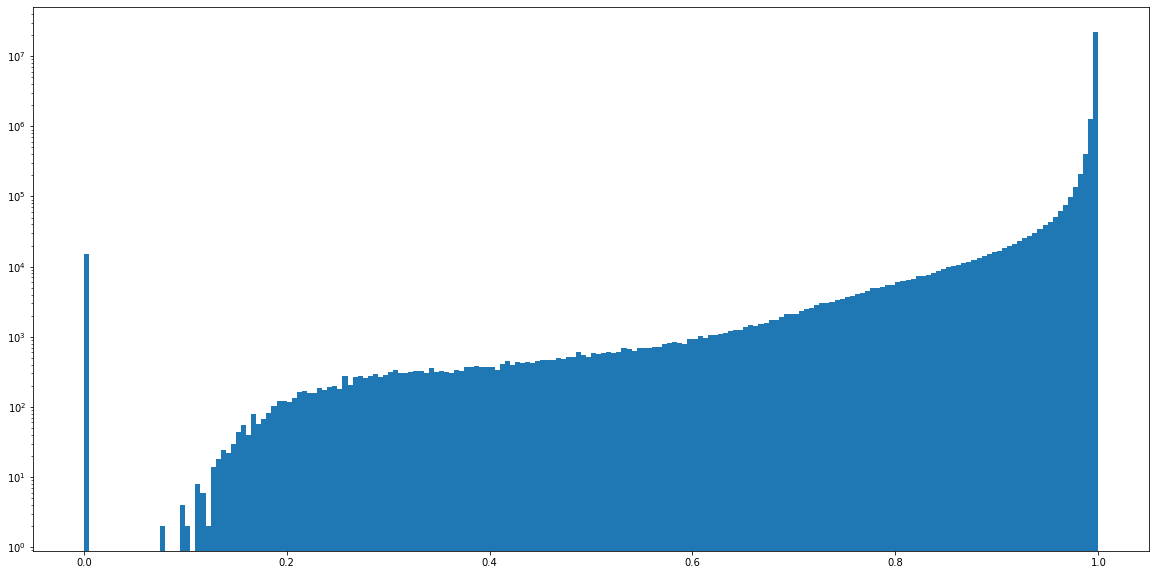

In [28]:
plt.figure(figsize = (20, 10))
plt.hist(y, bins = 200)
plt.yscale('log')
#plt.title()
#sns.kdeplot(y, alpha=.5).set(title="The observed distribution of distances != 1", xlabel='Distance', ylabel='Frequency')

Text(0.5, 1.0, 'The observed distribution of distances != 1')

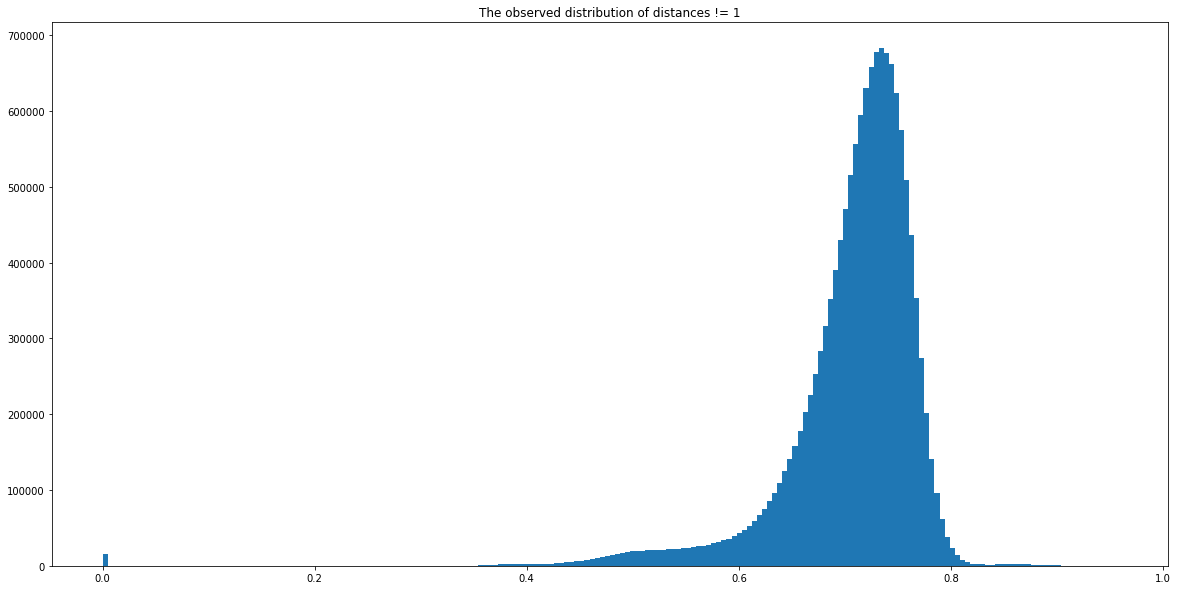

In [14]:
c = cooler.Cooler("/home/a.kuznetsov/data_new/0A_2000_down.cool")
bal = c.matrix(balance=True)[:, :]
X = np.logical_not(np.isnan(bal).all(axis=1))
test = mydist_balanced((bal[X, :][:, X]))
Z = test.flatten()
plt.figure(figsize = (20, 10))
plt.hist(Z[Z != 1.0], bins = 200)
plt.title("The observed distribution of distances != 1")

#Here I just checked that NaN bins deletion wouldn't change the resulted distribution.

We are mostly interested in the distances < 0.5 because of our maxrad = 0.5 parameter in the Eirene command.

## Data Processing.

In [28]:
Files = ["0A", "0B", "2A", "2B", "5A", "5B", "8A", "8B"]

In [53]:
for name in Files:
    c = cooler.Cooler("/gss/home/a.kuznetsov/data_new/"+name+"_2000_down.cool")
    bal = c.matrix(balance=True)[:, :]
    X = np.logical_not(np.isnan(bal).all(axis=1)) #We dicided to delete all the NaN values from the analysis
                                                    #due to their uninformativeness
    Deleted = np.arange(bal.shape[0])[~X] #Indices of deleted bins
    Saved = np.arange(bal.shape[0])[X] #Indices of saved bins
    np.save('/gss/home/a.kuznetsov/DM_indices/'+name+'_saved.npy', Saved)
    print(name+'_saved.npy is saved')
    np.save('/gss/home/a.kuznetsov/DM_indices/'+name+'_deleted.npy', Deleted)
    print (name+'_deleted.npy is saved')
    np.save('/gss/home/a.kuznetsov/NoNAN_DM_new/'+name+'.npy', p_dist((bal[X, :][:, X]))) #Distance matrix of non-NaN bins
    print (name+'.npy is saved')

0A_saved.npy is saved
0A_deleted.npy is saved
0A.npy is saved
0B_saved.npy is saved
0B_deleted.npy is saved
0B.npy is saved
2A_saved.npy is saved
2A_deleted.npy is saved
2A.npy is saved
2B_saved.npy is saved
2B_deleted.npy is saved
2B.npy is saved
5A_saved.npy is saved
5A_deleted.npy is saved
5A.npy is saved
5B_saved.npy is saved
5B_deleted.npy is saved
5B.npy is saved
8A_saved.npy is saved
8A_deleted.npy is saved
8A.npy is saved
8B_saved.npy is saved
8B_deleted.npy is saved
8B.npy is saved


## Result Verification.

In [44]:
for name in Files:
    X = np.load('/gss/home/a.kuznetsov/DM_indices/'+name+'_saved.npy')
    Y = np.load('/gss/home/a.kuznetsov/DM_indices/'+name+'_deleted.npy')
    Z = np.load('/gss/home/a.kuznetsov/NoNAN_DM_new/'+name+'.npy')
    print(X.shape, Y.shape, Z.shape)

(15122,) (2052,) (15122, 15122)
(15148,) (2026,) (15148, 15148)
(15386,) (1788,) (15386, 15386)
(15365,) (1809,) (15365, 15365)
(15333,) (1841,) (15333, 15333)
(15311,) (1863,) (15311, 15311)
(15288,) (1886,) (15288, 15288)
(15287,) (1887,) (15287, 15287)


In [49]:
from sklearn.utils.validation import check_symmetric
check_symmetric(Z, tol=1e-20)

array([[0.00000000e+00, 3.71852179e-01, 5.33651515e-01, ...,
        9.95865860e-01, 9.96037500e-01, 9.94374568e-01],
       [3.71852179e-01, 0.00000000e+00, 3.73940420e-01, ...,
        9.95349401e-01, 9.57720180e-01, 9.72377645e-01],
       [5.33651515e-01, 3.73940420e-01, 1.05367121e-08, ...,
        9.96011830e-01, 9.97404848e-01, 9.92803947e-01],
       ...,
       [9.95865860e-01, 9.95349401e-01, 9.96011830e-01, ...,
        0.00000000e+00, 1.00000685e+00, 9.98670701e-01],
       [9.96037500e-01, 9.57720180e-01, 9.97404848e-01, ...,
        1.00000685e+00, 1.05367121e-08, 5.61892199e-01],
       [9.94374568e-01, 9.72377645e-01, 9.92803947e-01, ...,
        9.98670701e-01, 5.61892199e-01, 0.00000000e+00]])

Text(0.5, 1.0, 'No-NaN Distance Map Fragment')

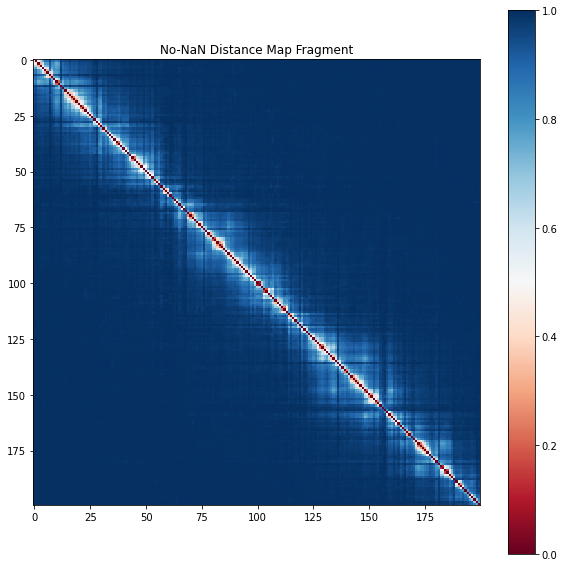

In [45]:
plt.figure(figsize = (10, 10))
plt.imshow(Z[1000:1200, 1000:1200], cmap='RdBu', interpolation='none')
plt.colorbar()
plt.title("No-NaN Distance Map Fragment")

In [7]:
Files = ["0A", "0B", "2A", "2B", "5A", "5B", "8A", "8B"]

for name in Files:
    print(name)
    X = np.load('/home/a.kuznetsov/DM_indices/'+name+'_saved.npy')
    Y = np.load('/home/a.kuznetsov/DM_indices/'+name+'_deleted.npy')
    print(X.shape, Y.shape)

0A
(15122,) (2052,)
0B
(15148,) (2026,)
2A
(15386,) (1788,)
2B
(15365,) (1809,)
5A
(15333,) (1841,)
5B
(15311,) (1863,)
8A
(15288,) (1886,)
8B
(15287,) (1887,)


In [8]:
for name in Files:
    print(name)
    X = np.load('/home/a.kuznetsov/Indices DM/'+name+'_saved.npy')
    Y = np.load('/home/a.kuznetsov/Indices DM/'+name+'_deleted.npy')
    print(X.shape, Y.shape)

0A
(15122,) (2052,)
0B
(15148,) (2026,)
2A
(15386,) (1788,)
2B
(15365,) (1809,)
5A
(15333,) (1841,)
5B
(15311,) (1863,)
8A
(15288,) (1886,)
8B
(15287,) (1887,)
